<a href="https://colab.research.google.com/github/landjbs/aimes/blob/master/ImageDetection%2BPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Object Analysis (showcase CNN only)

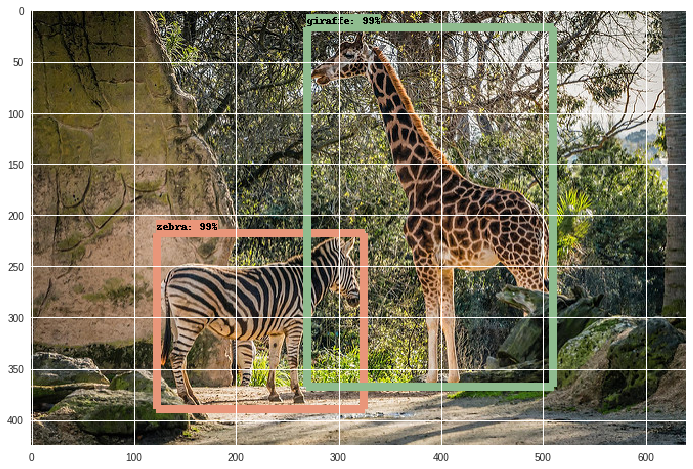

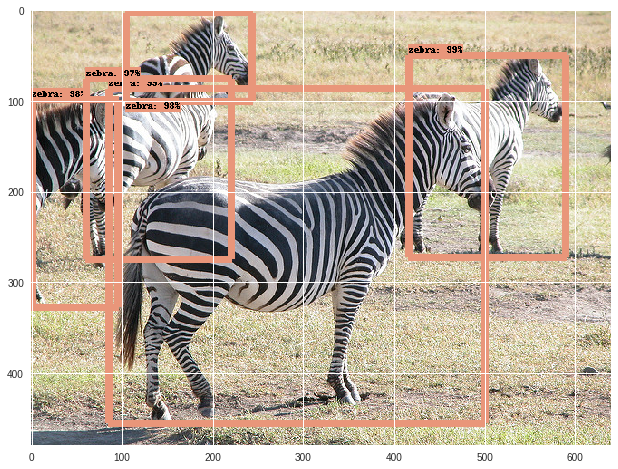

In [0]:
!mkdir images
!wget http://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg -O images/custom_img_2.jpg
!wget http://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg -O images/custom_img_1.jpg
!ls ./images/

PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'custom_img_{}.jpg'.format(i)) for i in range(1, 3) ]
IMAGE_SIZE = (12, 8)
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Configure environment/ Import libraries

In [1]:
#@title Imports and function definitions

!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

import numpy as np
import pandas as pd
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import time

from keras.models import Sequential
from keras.layers import Dense, Activation

Cloning into 'models'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 24206 (delta 0), reused 2 (delta 0), pack-reused 24198
Receiving objects: 100% (24206/24206), 563.19 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (14349/14349), done.
Checking out files: 100% (2792/2792), done.


/content/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    retu

# Train CNN for Object Detection

In [0]:
## IMPORT AND TRAIN MODEL ##
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# model with more accurancy but up to you use a diferent model
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## FUNCTION TO FORMAT PHOTO AS NUMPY ARRAY ##
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## FUNCTION TO DETECT OBJECTS FROM MULTI-PHOTO STACK ##
def detectObjects(photoList,visResults=True):
  """
  Args: List of photos stored as numpy arrays with dims (480,640,3)
  Returns: Matrix of 100 highest scores and corresponding item classes
  Prints: Plot of each image with boxes around identified objects
  """
  scoresMatrix,classesMatrix = [],[]
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      print(f"Processing {len(photoList)} photo(s):\n[",end="")
      for photo in photoList:
        image_np_expanded = np.expand_dims(photo, axis=0)
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        #append to matricies
        scoresMatrix.append(scores)
        classesMatrix.append(classes)
        print("=",end="")
        # plot pictures with boxes around objects
        if visResults == True:
          vis_util.visualize_boxes_and_labels_on_image_array(
              photo,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
          plt.figure(figsize=(12,8))
          plt.imshow(photo)
      scoresMatrix, classesMatrix = np.asarray(scoresMatrix), np.asarray(classesMatrix)
      print(f"]\n{len(photoList)} photos analyzed for matricies of object scores and categories with shapes of {scoresMatrix.shape}!")
      return scoresMatrix,classesMatrix

# Capture and process training images

In [0]:
def take_photos(filename='photo.jpg', quality=0.8, numPhotos=2):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  photoList=[]
  for photo in range(numPhotos):
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    rawPhoto = Image.open(filename)
    photoData = load_image_into_numpy_array(rawPhoto)
    photoList.append(photoData)
  return photoList

**Long Trial (60 im)**
1.   Person --> Person + Banana
2.   Person + Bottle --> Person
3.   Person + Banana+Fork --> Person+Bottle
4.   Cup --> Person + Cup
5.   Bottle -->  Person + Banana
6.   Banana --> Cup

In [0]:
photoList = take_photos(numPhotos=60)

<IPython.core.display.Javascript object>

In [0]:
scoresMatrix_train, classesMatrix_train = detectObjects(photoList,visResults=False)

Processing 60 photo(s):
[============================================================]
60 photos analyzed for matricies of object scores and categories with shapes of (60, 1, 100)!


# Analyze training images and train prediction model

In [0]:
## FUNCTION TO GET ITEMS LIST IN MULTI-PHOTO STACK ##
def getItems_train(scoresMatrix, classesMatrix, category_index=category_index):
  """
  Args: Matrix of classes and scores generated from photoList by detectObjects(),
  category_index (dict) used to translate classes to item name
  Returns: 2D itemsList of items in photoList (rows: list of items in individual pic)
  and list of all item types across photos
  """
  itemsList,itemTypes = [],[]
  for photoNum, photoScores in enumerate(scoresMatrix):
    print(f"Photo {photoNum}:")
    curPhoto_items=[]
    for itemCounter, itemScore in enumerate(photoScores[0]):
      if itemScore > 0.8:
        curItem = category_index[(classesMatrix[photoNum][0][itemCounter])]['name']
        print(f"    Item: {curItem}\n    Score: {itemScore}")
        curPhoto_items.append(curItem)
        if curItem not in itemTypes: itemTypes.append(curItem)
    itemsList.append(curPhoto_items)
  return itemsList, itemTypes

## FUNCTION TO GET ITEMS LIST IN SINGLE PHOTO ##
def getItems_test(scoresMatrix, classesMatrix, category_index=category_index):
  """
  Args: Matrix of classes and scores generated from photoList by detectObjects(),
  category_index (dict) used to translate classes to item name
  Returns: 2D itemsList of items in photoList (rows: list of items in individual pic)
  """
  itemsList = []
  for photoNum, photoScores in enumerate(scoresMatrix):
    print(f"\nPhoto {photoNum}:")
    curPhoto_items=[]
    for itemCounter, itemScore in enumerate(photoScores[0]):
      if itemScore > 0.8:
        curItem = category_index[(classesMatrix[photoNum][0][itemCounter])]['name']
        print(f"    Item: {curItem}\n    Score: {itemScore}")
        curPhoto_items.append(curItem)
    itemsList.append(curPhoto_items)
  return itemsList

# function for dividing features and targets from item list of multi-photo stack
## FUNCITON TO DIVIDE FEATUES AND TARGETS FROM ITEM LIST IN MULTI- OR SINGLE PHOTO ##
def process_trainingData(itemsList):
  """
  Args: Complete list of items in each of a multi-photo stack
  Returns: featureItems list of features (items in prev photo) for each photo,
  targetItems list of targets (new items in cur photo) for each photo
  """
  # featureItems is the items in the previous picture, targetItems is the items that 
  # are new in the current picture
  featureItems,targetItems = [],[]
  for photoNum, photo in enumerate(itemsList):
    curPhoto_targetItems=[]
    for itemNum, item in enumerate(photo):
      if item not in itemsList[photoNum-1]:
        curPhoto_targetItems.append(item)
    targetItems.append(curPhoto_targetItems)
    if photoNum != 0:
        featureItems.append(itemsList[photoNum-1])
    else: featureItems.append(["NA"])
  return featureItems, targetItems

# function for one-hot encoding; use AFTER dividing features and targets 
def itemsList_to_categoricals(itemList,itemTypes):
  """
  Args: List of items in each of a multi-photo stack; itemTypes list of all 
  items detected
  Returns: Matrix of one-hot encoded items with row length of len(itemTypes)
  where 1 signifies an object's presence in a photo
  """
  encodedList=[]
  for photo in itemList:
    binaryItems = np.zeros(len(itemTypes))
    for counter, itemType in enumerate(itemTypes):
      if itemType in photo:
        binaryItems[counter] = 1
    encodedList.append(binaryItems)
    encodedMatrix = np.asarray(encodedList)
  return encodedMatrix

# REMINDER TO IMPLEMENT MULTI-MODEL WHERE EACH OBJECT HAS A ONE-HOT ENCODING
# (ie. multiple arrays per row); downsides-time, upsides-can understand multiple
# of the same object in a frame

# use for a single photo to encode all items it contains
def singlePhoto_to_categoricals(itemList,itemTypes):
  binaryItems = np.zeros(len(itemTypes))
  for counter, itemType in enumerate(itemTypes):
    if itemType in itemList:
      binaryItems[counter] = 1
  return binaryItems

## FUNCTION TO FIT PREDICTION MODEL ##
def fit_predictionModel(encodedFeatures, encodedTargets, itemTypes, epochs=10, batch_size=1):
  """
  Args: Matrices of one-hot encoded features and scores, list of item types, 
  epochs and batch size to specify model training parameters.
  Returns: Model fit to enocdedFeatures and encodedTargets
  """
  numItems = len(itemTypes)
  # define layers of and compile model
  predictionModel = Sequential([
    Dense(300, input_shape=(numItems,)),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(numItems,),
    Activation('softmax'),
    ])
  # compile prediciton model
  predictionModel.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  print("\nTraining Model:")
  # fit model to train data
  predictionModel.fit(encodedFeatures, encodedTargets, epochs=epochs, batch_size=batch_size)
    
  print(f"\nModel ({predictionModel}) fit to data!")
  return predictionModel

## FUNCTION TO GENERATE FAKE PICTURES ##
def gen_itemList(numItr):
  """
  Args: number of data generating iterations
  Returns: list of lists of items in each picture; list of all items across pictures
  """
  trafficGroup = ['traffic light', 'car', 'bus', 'motercycle', 'bus', 'person', 'truck', 'stop sign', 'bicycle', 'parking meter']
  farmGroup = ['horse', 'sheep', 'cow']
  safariGroup = ['elephant', 'zebra', 'giraffe']
  clothingGroup = ['person', 'handbag', 'umbrella', 'tie', 'backpack']
  snowGroup = ['skis', 'snowboard', 'person']
  baseballGroup = ['baseball bat', 'baseball glove', 'sports ball']
  tennisGroup = ['tennis racket', 'sports ball', 'person']
  dinnerGroup = ['knife', 'fork', 'wine glass', 'cup', 'person']
  drinksGroup = ['bottle', 'wine glass', 'cup']
  soupGroup = ['bowl', 'spoon']
  fruitGroup = ['apple', 'orange', 'banana']
  vegtablesGroup = ['broccoli', 'carrot']
  fastfoodGroup = ['hot dog', 'pizza', 'donut','cake']
  livingroomGroup = ['chair', 'couch', 'potted plant', 'person', 'tv', 'remote']
  computerGroup = ['laptop', 'mouse', 'keyboard']
  kitchenGroup = ['microwave', 'oven', 'toaster', 'sink', 'refrigerator']
  bathroomGroup = ['sink', 'toothbrush', 'toilet']
  
  groupsList = [trafficGroup, farmGroup, safariGroup, clothingGroup, snowGroup, 
                baseballGroup, tennisGroup, dinnerGroup, drinksGroup, soupGroup, 
                fruitGroup, vegtablesGroup, fastfoodGroup, livingroomGroup, 
                computerGroup, kitchenGroup, bathroomGroup]
  
  numGroups = len(groupsList)
  iterationMarker = numItr/10
  itemsList_generated = []
  print("Generating Data: [", end='')
  for iteration in range(numItr):
    if iteration % iterationMarker == 0: print("=", end="")
    # select random group
    curGroup = groupsList[np.random.randint(numGroups)]
    # number of samplings from group
    for picture in range(np.random.randint(1,15)):
      curPic=[]
      for i in range(np.random.randint(1,4)):
        curPic.append(curGroup[np.random.randint(0,len(curGroup))])
      itemsList_generated.append(curPic)
  print("]")
  
  itemTypes=[]
  for group in groupsList:
    for item in group:
      if item not in itemTypes: itemTypes.append(item)
  
  return itemsList_generated, itemTypes




# FUNCTION TO PROCESS ITEMS LIST AND ITEM TYPES INTO ENCODED FEATURES AND TARGETS
def process_trainingItems(itemsList, itemTypes, epochs=10, batch_size=1):
  """
  Args: multi-stack itemsList for training; list of all item types
  Returns: prediction model fit to training data
  """
  # process item array into target matrix of new items in current photo and feature matrix of all items in previous photo
  featureItems, targetItems = process_trainingData(itemsList)
  print("Data processed")
  
  # one-hot encoded features and targets as binary presence of each item
  encodedFeatures = itemsList_to_categoricals(featureItems, itemTypes=itemTypes)
  encodedTargets = itemsList_to_categoricals(targetItems, itemTypes=itemTypes)
  print("Features encoded")

  # train prediction model on encoded features and targets
  predictionModel = fit_predictionModel(encodedFeatures, encodedTargets, epochs=epochs, batch_size=batch_size, itemTypes=itemTypes)
  
  return predictionModel




# FUNCTION TO TEST PREDICTION MODEL ON A SINGLE INPUT PHOTO #
def test_predictionModel_photo(photoList_test, predictionModel, visResults=False):
  """
  Args: photoList containing a single picture as numpy array, which predictionModel 
  to use for sequence prediciton, visResults (bool) of whether or not to show object
  detection photo
  Returns: vecotr of predictionModel predictions for each item in itemTypes 
  (itemTypes is contained wihtin predictionModel)
  """
  # detect objects in test picture
  scoresMatrix_test, classesMatrix_test = detectObjects(photoList_test, visResults=visResults)

  # identify items in test picture
  itemsList_test = getItems_test(scoresMatrix=scoresMatrix_test, classesMatrix=classesMatrix_test, category_index=category_index)

  # one-hot encoded features and targets as binary presence of each item
  encodedItems_test = singlePhoto_to_categoricals(itemsList_test[0], itemTypes=itemTypes_gen)
  encodedItems_test = np.expand_dims(encodedItems_test, axis=0)

  # create prediction vector with scores of potential new objects in next picture
  predictionVector = predictionModel.predict(encodedItems_test)

  return predictionVector




# FUNCTION TO ANALYZE THE PREDICITON VECOTR FOR ITEM PREDICTION #
def analyze_predictionVector(predictionVector, itemTypes, scoreCutoff=95, printAll=False):
  """
  Args: predictionVector from predictionModel of scores for each possible 
  obejct in next image, list of item types, cutoff to count as "likely object" (
  if scoreCutoff=1, only the max item will be counted)
  Returns: List of items with scores above scoreCutoff
  Print: Each possible item and the corresponding weight
  """
  likelyObjects=[]
  
  # if score cutoff is 100, return only the item with max prediction
  if scoreCutoff == 100: 
    percentile = max(predictionVector[0])
  # else set percenilte to scores within percentile of score cutoff
  else: percentile = np.percentile(predictionVector[0], scoreCutoff)
    
  # find items in percentile
  for i in range(len(predictionVector[0])):
    if predictionVector[0][i] >= percentile: likelyObjects.append(itemTypes[i])
      
  # visualize results for ever item
  if printAll==True:
    print("\nPrediction Vector Analysis:")
    for i in range(len(predictionVector[0])):
      print(f"    Item: {itemTypes[i]}\n    Prediciton Weight: {predictionVector[0][i]}\n")
      
  return likelyObjects

In [0]:
## To get itemsList from real photos ##

# find items in each picture of photoList
itemsList_pics, itemTypes_pics = getItems_train(scoresMatrix=scoresMatrix_train, classesMatrix=classesMatrix_train, category_index=category_index)

predicitionModel_pics = process_trainingItems(itemsList=itemsList_pics, itemTypes=itemTypes_pics)

In [0]:
## Assuming itemsList_fromString has already been created ##

predictionModel_fromString = process_trainingItems(itemsList=itemsList_fromString, itemTypes=itemTypes_gen)

In [19]:
## Generate and train on fake photo dataset ##

# generate item array # 
itemsList_gen, itemTypes_gen = gen_itemList(numItr=1000) 

predictionModel_gen = process_trainingItems(itemsList=itemsList_gen, itemTypes=itemTypes_gen, batch_size=20)

Generating Data: [==========]
Data processed
Features encoded

Training Model:
Epoch 1/10
7375/7375 [==============================] - 1s 201us/step - loss: 2.6855 - acc: 0.2565
Epoch 2/10
7375/7375 [==============================] - 1s 175us/step - loss: 2.1976 - acc: 0.3085
Epoch 3/10
7375/7375 [==============================] - 1s 168us/step - loss: 2.1253 - acc: 0.3186
Epoch 4/10
7375/7375 [==============================] - 1s 162us/step - loss: 2.0747 - acc: 0.3193
Epoch 5/10
7375/7375 [==============================] - 1s 163us/step - loss: 2.0425 - acc: 0.3111
Epoch 6/10
7375/7375 [==============================] - 1s 165us/step - loss: 2.0148 - acc: 0.3254
Epoch 7/10
7375/7375 [==============================] - 1s 161us/step - loss: 2.0009 - acc: 0.3188
Epoch 8/10
7375/7375 [==============================] - 1s 161us/step - loss: 1.9784 - acc: 0.3196
Epoch 9/10
7375/7375 [==============================] - 1s 165us/step - loss: 1.9720 - acc: 0.3257
Epoch 10/10
7375/7375 [=======

# Test: Object Detection and Prediciton

In [87]:
# take test photo
photoList_test = take_photos(numPhotos=1)

predictionVector = test_predictionModel_photo(photoList_test=photoList_test, predictionModel=predicitonModel_gen, visResults=False)

# analyze prediction vector for likely objects
likelyObjects = analyze_predictionVector(predictionVector, scoreCutoff=95, itemTypes=itemTypes_gen, printAll=False)

<IPython.core.display.Javascript object>

Processing 1 photo(s):
[=]
1 photos analyzed for matricies of object scores and categories with shapes of (1, 1, 100)!

Photo 0:
    Item: chair
    Score: 0.9684959053993225
    Item: tv
    Score: 0.9600062966346741
    Item: couch
    Score: 0.9589489102363586
    Item: chair
    Score: 0.9458957314491272

Prediction Vector Analysis:


In [1]:
photoList_test = take_photos(numPhotos=1)

predictionVector = test_predictionModel_photo(photoList_test=photoList_test, predictionModel=predicitonModel_gen, visResults=False)

likelyObjects = analyze_predictionVector(predictionVector, scoreCutoff=100, itemTypes=itemTypes_gen, printAll=False)

#while not desireList.issubset(likelyObjects):

desireList = set(["wine glass"])

# has something new been added to likely objects this iteration?
curAppend = True

step = 0

while not desireList.issubset(set(likelyObjects)):
  # one-hot encoded features and targets as binary presence of each item
  encodedItems_test = singlePhoto_to_categoricals(likelyObjects, itemTypes=itemTypes_gen)
  encodedItems_test = np.expand_dims(encodedItems_test, axis=0)

  # create prediction vector with scores of potential new objects in next picture
  predictionVector = predictionModel_gen.predict(encodedItems_test)  

  if curAppend == True:
    curScore = 100
  #else: curScore -= 5
  
  # add likely objects from prediciton vector
  curLikely = (analyze_predictionVector(predictionVector, scoreCutoff=curScore, itemTypes=itemTypes_gen, printAll=False))
  stepItems = []
  
  curAppend = False
  
  for item in curLikely:
    if item not in likelyObjects: 
      likelyObjects.append(item)
      stepItems.append(item)
      curAppend = True
      curScore = 100
      
  print(f"Step {step}: {stepItems}")
  step += 1

NameError: ignored

In [0]:
#def findDesire(photList_test, predictionModel, desireList):
  likelyObjects = set()
  while not desireList.issubset(likelyObjects):
    predictionVector = test_predictionModel_photo(photoList_test=photoList_test, predictionModel=predicitonModel_gen, visResults=False)
    likelyObjects = set(analyze_predictionVector(predictionVector, scoreCutoff=95, itemTypes=itemTypes_gen, printAll=False))
    print(likelyObjects)

In [0]:
findDesire(photoList_test, predictionModel_gen, desireList)

# Testing data

Test circumstances:
*   photoList Length: 6
*   Pattern:                  [person, person+bottle, person+knife]
*   Num Repetitions: 2

**Person Present** (Most likely prediction: Bottle)
*   Person;  Weight: 0.22689
*   Bottle;    Weight: 0.41016
*   Knife;     Weight: 0.36715


**Person + Bottle Present** (Most likely prediction: Knife)
*   Person;  Weight: 0.15018
*   Bottle;    Weight: 0.41290
*   Knife;     Weight: 0.43691

**Person + Knife Present** (Most likely prediciton: Knife)
*   Person;  Weight: 0.22559
*   Bottle;    Weight: 0.35553
*   Knife;     Weight: 0.41887

In [38]:
text = """Photo 0:
    Item: person
    Score: 0.9999343156814575
Photo 1:
    Item: person
    Score: 0.9996464252471924
    Item: banana
    Score: 0.9993370175361633
Photo 2:
    Item: person
    Score: 0.9998117089271545
    Item: bottle
    Score: 0.8254178166389465
Photo 3:
    Item: person
    Score: 0.9997835755348206
Photo 4:
    Item: person
    Score: 0.9993345141410828
    Item: banana
    Score: 0.9984138011932373
    Item: fork
    Score: 0.974125325679779
Photo 5:
    Item: person
    Score: 0.9998528957366943
    Item: bottle
    Score: 0.8932482600212097
Photo 6:
    Item: cup
    Score: 0.9970833659172058
    Item: person
    Score: 0.8621718287467957
Photo 7:
    Item: cup
    Score: 0.9989128112792969
    Item: person
    Score: 0.9981226325035095
    Item: person
    Score: 0.8763361573219299
Photo 8:
    Item: person
    Score: 0.9125708937644958
    Item: bottle
    Score: 0.8894302248954773
Photo 9:
    Item: person
    Score: 0.9995874762535095
    Item: banana
    Score: 0.9984540939331055
Photo 10:
    Item: banana
    Score: 0.9951090216636658
    Item: person
    Score: 0.9197176694869995
Photo 11:
    Item: person
    Score: 0.8824835419654846
    Item: cup
    Score: 0.8324649930000305
Photo 12:
    Item: person
    Score: 0.9998863935470581
Photo 13:
    Item: banana
    Score: 0.9993588328361511
    Item: person
    Score: 0.9990565180778503
Photo 14:
    Item: person
    Score: 0.9992819428443909
Photo 15:
    Item: person
    Score: 0.9998041987419128
Photo 16:
    Item: banana
    Score: 0.9991441965103149
    Item: person
    Score: 0.9988701939582825
    Item: fork
    Score: 0.9776753783226013
Photo 17:
    Item: person
    Score: 0.9995162487030029
Photo 18:
    Item: cup
    Score: 0.9811064004898071
    Item: person
    Score: 0.9338759779930115
Photo 19:
    Item: cup
    Score: 0.99587482213974
    Item: person
    Score: 0.9929543137550354
    Item: person
    Score: 0.9517565369606018
Photo 20:
    Item: bottle
    Score: 0.9106026291847229
Photo 21:
    Item: banana
    Score: 0.999271810054779
    Item: person
    Score: 0.9982149600982666
Photo 22:
    Item: banana
    Score: 0.9972109198570251
Photo 23:
    Item: cup
    Score: 0.9936472773551941
Photo 24:
    Item: person
    Score: 0.9998544454574585
Photo 25:
    Item: banana
    Score: 0.9990895986557007
    Item: person
    Score: 0.9989965558052063
Photo 26:
    Item: person
    Score: 0.9989182949066162
    Item: bottle
    Score: 0.9617338180541992
    Item: person
    Score: 0.9212760329246521
Photo 27:
    Item: person
    Score: 0.9997907280921936
Photo 28:
    Item: person
    Score: 0.9986352324485779
    Item: banana
    Score: 0.9982531666755676
    Item: fork
    Score: 0.9331858158111572
Photo 29:
    Item: person
    Score: 0.9994254112243652
    Item: bottle
    Score: 0.9830709099769592
Photo 30:
    Item: cup
    Score: 0.9079801440238953
    Item: person
    Score: 0.8788675665855408
Photo 31:
    Item: person
    Score: 0.9986617565155029
    Item: cup
    Score: 0.9961320161819458
Photo 32:
    Item: bottle
    Score: 0.8775458335876465
Photo 33:
    Item: banana
    Score: 0.9989217519760132
    Item: person
    Score: 0.9988089799880981
    Item: person
    Score: 0.816697359085083
Photo 34:
    Item: banana
    Score: 0.9954183101654053
    Item: person
    Score: 0.919756293296814
Photo 35:
    Item: cup
    Score: 0.9450920820236206
Photo 36:
    Item: person
    Score: 0.9997827410697937
Photo 37:
    Item: banana
    Score: 0.9987987279891968
    Item: person
    Score: 0.9971703886985779
    Item: person
    Score: 0.9729183316230774
    Item: person
    Score: 0.8943341374397278
Photo 38:
    Item: person
    Score: 0.9981796741485596
    Item: person
    Score: 0.9446176290512085
    Item: bottle
    Score: 0.8749712109565735
Photo 39:
    Item: person
    Score: 0.9998564720153809
Photo 40:
    Item: person
    Score: 0.9992139339447021
    Item: banana
    Score: 0.9987094402313232
    Item: fork
    Score: 0.979841947555542
Photo 41:
    Item: person
    Score: 0.9991065859794617
    Item: person
    Score: 0.9454735517501831
Photo 42:
    Item: cup
    Score: 0.994498074054718
    Item: person
    Score: 0.892276406288147
Photo 43:
    Item: person
    Score: 0.9986597299575806
    Item: cup
    Score: 0.9981279969215393
Photo 44:
    Item: bottle
    Score: 0.8768664598464966
Photo 45:
    Item: banana
    Score: 0.9995786547660828
    Item: person
    Score: 0.9976692795753479
Photo 46:
    Item: banana
    Score: 0.9966402053833008
Photo 47:
    Item: cup
    Score: 0.9980175495147705
Photo 48:
    Item: person
    Score: 0.9993810653686523
    Item: bed
    Score: 0.8194447755813599
Photo 49:
    Item: person
    Score: 0.9987607002258301
    Item: banana
    Score: 0.9983811378479004
Photo 50:
    Item: person
    Score: 0.9995492100715637
    Item: bottle
    Score: 0.9840286374092102
    Item: bed
    Score: 0.8807700276374817
Photo 51:
    Item: person
    Score: 0.9996578693389893
Photo 52:
    Item: banana
    Score: 0.9990861415863037
    Item: person
    Score: 0.996828019618988
    Item: fork
    Score: 0.9832485914230347
Photo 53:
    Item: person
    Score: 0.998383641242981
    Item: bottle
    Score: 0.9802019000053406
Photo 54:
    Item: cup
    Score: 0.9703100919723511
    Item: person
    Score: 0.8877679109573364
Photo 55:
    Item: cup
    Score: 0.9982759952545166
    Item: person
    Score: 0.9925296902656555
Photo 56:
    Item: bottle
    Score: 0.961661159992218
Photo 57:
    Item: banana
    Score: 0.9992398023605347
    Item: person
    Score: 0.9967882633209229
Photo 58:
    Item: banana
    Score: 0.9960297346115112
Photo 59:
    Item: cup
    Score: 0.9970158338546753"""

## FUNCTION TO GET LIST OF ITEMS FROM STRING OF OBJECT-DETECTION OUTPUT ##
########## WARNGING: NOT FININSHED ##########
def itemsList_fromString(string):
  """
  Args: string output from detectObjects
  Returns: list of items in each picture; list of all item types
  """
  string = string.split("\n")
  itemsList = []
  itemTypes = ['person', 'banana', 'bottle', 'fork', 'cup', 'bed']
  curList=[]
  for word in string:
    if word.startswith("Photo"): 
      itemsList.append(curList)
      curList=[]
    if word.startswith("    Item"):  
      for item in itemTypes: 
        if item in word:
          curList.append(item)
  return itemsList, itemTypes

itemsList_fromString, itemTypes = itemsList_fromString(string=text)
itemsList_fromString.append(["cup"])
itemsList_fromString = itemsList_fromString[1:(len(itemsList_fromString))]

print((itemsList_fromString))

[['person'], ['person', 'banana'], ['person', 'bottle'], ['person'], ['person', 'banana', 'fork'], ['person', 'bottle'], ['cup', 'person'], ['cup', 'person', 'person'], ['person', 'bottle'], ['person', 'banana'], ['banana', 'person'], ['person', 'cup'], ['person'], ['banana', 'person'], ['person'], ['person'], ['banana', 'person', 'fork'], ['person'], ['cup', 'person'], ['cup', 'person', 'person'], ['bottle'], ['banana', 'person'], ['banana'], ['cup'], ['person'], ['banana', 'person'], ['person', 'bottle', 'person'], ['person'], ['person', 'banana', 'fork'], ['person', 'bottle'], ['cup', 'person'], ['person', 'cup'], ['bottle'], ['banana', 'person', 'person'], ['banana', 'person'], ['cup'], ['person'], ['banana', 'person', 'person', 'person'], ['person', 'person', 'bottle'], ['person'], ['person', 'banana', 'fork'], ['person', 'person'], ['cup', 'person'], ['person', 'cup'], ['bottle'], ['banana', 'person'], ['banana'], ['cup'], ['person', 'bed'], ['person', 'banana'], ['person', 'bott

60 im Test:

**Detection and Processing Data:**

Photo 0:
    Item: person
    Score: 0.9999343156814575
Photo 1:
    Item: person
    Score: 0.9996464252471924
    Item: banana
    Score: 0.9993370175361633
Photo 2:
    Item: person
    Score: 0.9998117089271545
    Item: bottle
    Score: 0.8254178166389465
Photo 3:
    Item: person
    Score: 0.9997835755348206
Photo 4:
    Item: person
    Score: 0.9993345141410828
    Item: banana
    Score: 0.9984138011932373
    Item: fork
    Score: 0.974125325679779
Photo 5:
    Item: person
    Score: 0.9998528957366943
    Item: bottle
    Score: 0.8932482600212097
Photo 6:
    Item: cup
    Score: 0.9970833659172058
    Item: person
    Score: 0.8621718287467957
Photo 7:
    Item: cup
    Score: 0.9989128112792969
    Item: person
    Score: 0.9981226325035095
    Item: person
    Score: 0.8763361573219299
Photo 8:
    Item: person
    Score: 0.9125708937644958
    Item: bottle
    Score: 0.8894302248954773
Photo 9:
    Item: person
    Score: 0.9995874762535095
    Item: banana
    Score: 0.9984540939331055
Photo 10:
    Item: banana
    Score: 0.9951090216636658
    Item: person
    Score: 0.9197176694869995
Photo 11:
    Item: person
    Score: 0.8824835419654846
    Item: cup
    Score: 0.8324649930000305
Photo 12:
    Item: person
    Score: 0.9998863935470581
Photo 13:
    Item: banana
    Score: 0.9993588328361511
    Item: person
    Score: 0.9990565180778503
Photo 14:
    Item: person
    Score: 0.9992819428443909
Photo 15:
    Item: person
    Score: 0.9998041987419128
Photo 16:
    Item: banana
    Score: 0.9991441965103149
    Item: person
    Score: 0.9988701939582825
    Item: fork
    Score: 0.9776753783226013
Photo 17:
    Item: person
    Score: 0.9995162487030029
Photo 18:
    Item: cup
    Score: 0.9811064004898071
    Item: person
    Score: 0.9338759779930115
Photo 19:
    Item: cup
    Score: 0.99587482213974
    Item: person
    Score: 0.9929543137550354
    Item: person
    Score: 0.9517565369606018
Photo 20:
    Item: bottle
    Score: 0.9106026291847229
Photo 21:
    Item: banana
    Score: 0.999271810054779
    Item: person
    Score: 0.9982149600982666
Photo 22:
    Item: banana
    Score: 0.9972109198570251
Photo 23:
    Item: cup
    Score: 0.9936472773551941
Photo 24:
    Item: person
    Score: 0.9998544454574585
Photo 25:
    Item: banana
    Score: 0.9990895986557007
    Item: person
    Score: 0.9989965558052063
Photo 26:
    Item: person
    Score: 0.9989182949066162
    Item: bottle
    Score: 0.9617338180541992
    Item: person
    Score: 0.9212760329246521
Photo 27:
    Item: person
    Score: 0.9997907280921936
Photo 28:
    Item: person
    Score: 0.9986352324485779
    Item: banana
    Score: 0.9982531666755676
    Item: fork
    Score: 0.9331858158111572
Photo 29:
    Item: person
    Score: 0.9994254112243652
    Item: bottle
    Score: 0.9830709099769592
Photo 30:
    Item: cup
    Score: 0.9079801440238953
    Item: person
    Score: 0.8788675665855408
Photo 31:
    Item: person
    Score: 0.9986617565155029
    Item: cup
    Score: 0.9961320161819458
Photo 32:
    Item: bottle
    Score: 0.8775458335876465
Photo 33:
    Item: banana
    Score: 0.9989217519760132
    Item: person
    Score: 0.9988089799880981
    Item: person
    Score: 0.816697359085083
Photo 34:
    Item: banana
    Score: 0.9954183101654053
    Item: person
    Score: 0.919756293296814
Photo 35:
    Item: cup
    Score: 0.9450920820236206
Photo 36:
    Item: person
    Score: 0.9997827410697937
Photo 37:
    Item: banana
    Score: 0.9987987279891968
    Item: person
    Score: 0.9971703886985779
    Item: person
    Score: 0.9729183316230774
    Item: person
    Score: 0.8943341374397278
Photo 38:
    Item: person
    Score: 0.9981796741485596
    Item: person
    Score: 0.9446176290512085
    Item: bottle
    Score: 0.8749712109565735
Photo 39:
    Item: person
    Score: 0.9998564720153809
Photo 40:
    Item: person
    Score: 0.9992139339447021
    Item: banana
    Score: 0.9987094402313232
    Item: fork
    Score: 0.979841947555542
Photo 41:
    Item: person
    Score: 0.9991065859794617
    Item: person
    Score: 0.9454735517501831
Photo 42:
    Item: cup
    Score: 0.994498074054718
    Item: person
    Score: 0.892276406288147
Photo 43:
    Item: person
    Score: 0.9986597299575806
    Item: cup
    Score: 0.9981279969215393
Photo 44:
    Item: bottle
    Score: 0.8768664598464966
Photo 45:
    Item: banana
    Score: 0.9995786547660828
    Item: person
    Score: 0.9976692795753479
Photo 46:
    Item: banana
    Score: 0.9966402053833008
Photo 47:
    Item: cup
    Score: 0.9980175495147705
Photo 48:
    Item: person
    Score: 0.9993810653686523
    Item: bed
    Score: 0.8194447755813599
Photo 49:
    Item: person
    Score: 0.9987607002258301
    Item: banana
    Score: 0.9983811378479004
Photo 50:
    Item: person
    Score: 0.9995492100715637
    Item: bottle
    Score: 0.9840286374092102
    Item: bed
    Score: 0.8807700276374817
Photo 51:
    Item: person
    Score: 0.9996578693389893
Photo 52:
    Item: banana
    Score: 0.9990861415863037
    Item: person
    Score: 0.996828019618988
    Item: fork
    Score: 0.9832485914230347
Photo 53:
    Item: person
    Score: 0.998383641242981
    Item: bottle
    Score: 0.9802019000053406
Photo 54:
    Item: cup
    Score: 0.9703100919723511
    Item: person
    Score: 0.8877679109573364
Photo 55:
    Item: cup
    Score: 0.9982759952545166
    Item: person
    Score: 0.9925296902656555
Photo 56:
    Item: bottle
    Score: 0.961661159992218
Photo 57:
    Item: banana
    Score: 0.9992398023605347
    Item: person
    Score: 0.9967882633209229
Photo 58:
    Item: banana
    Score: 0.9960297346115112
Photo 59:
    Item: cup
    Score: 0.9970158338546753

Training Model:
Epoch 1/10
60/60 [==============================] - 2s 40ms/step - loss: 1.5988 - acc: 0.1000
Epoch 2/10
60/60 [==============================] - 0s 1ms/step - loss: 1.5185 - acc: 0.1833
Epoch 3/10
60/60 [==============================] - 0s 1ms/step - loss: 1.4513 - acc: 0.1833
Epoch 4/10
60/60 [==============================] - 1s 12ms/step - loss: 1.3962 - acc: 0.2833
Epoch 5/10
60/60 [==============================] - 0s 1ms/step - loss: 1.3518 - acc: 0.3833
Epoch 6/10
60/60 [==============================] - 0s 1ms/step - loss: 1.3130 - acc: 0.3833
Epoch 7/10
60/60 [==============================] - 0s 1ms/step - loss: 1.2769 - acc: 0.3833
Epoch 8/10
60/60 [==============================] - 0s 1ms/step - loss: 1.2462 - acc: 0.3833
Epoch 9/10
60/60 [==============================] - 0s 1ms/step - loss: 1.2179 - acc: 0.3833
Epoch 10/10
60/60 [==============================] - 0s 1ms/step - loss: 1.1908 - acc: 0.3833

Model (<keras.engine.sequential.Sequential object at 0x7f9b6f029668>) fit to data!



**Prediction Data:**

*Person:* 

Precition Vector Analysis:
    Item: person
    Prediciton Weight: 0.07105705887079239

    Item: banana
    Prediciton Weight: 0.35775381326675415

    Item: bottle
    Prediciton Weight: 0.24235539138317108

    Item: fork
    Prediciton Weight: 0.14030036330223083

    Item: cup
    Prediciton Weight: 0.1564466953277588

    Item: bed
    Prediciton Weight: 0.03208671137690544

Likely Obejects:
    ['banana']
    
 *Person + Banana:*

Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.08450976014137268

    Item: banana
    Prediciton Weight: 0.19592715799808502

    Item: bottle
    Prediciton Weight: 0.3697747588157654

    Item: fork
    Prediciton Weight: 0.08542762696743011

    Item: cup
    Prediciton Weight: 0.23106543719768524

    Item: bed
    Prediciton Weight: 0.03329526633024216

Likely Obejects:
    ['bottle']
    
 *Person + Bottle:*
 
 Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.08265987038612366

    Item: banana
    Prediciton Weight: 0.3901381492614746

    Item: bottle
    Prediciton Weight: 0.21744295954704285

    Item: fork
    Prediciton Weight: 0.09474126249551773

    Item: cup
    Prediciton Weight: 0.1895383596420288

    Item: bed
    Prediciton Weight: 0.02547946386039257

Likely Obejects:
    ['banana']
    
*Person + Banana + Fork:*

Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.08450976014137268

    Item: banana
    Prediciton Weight: 0.19592715799808502

    Item: bottle
    Prediciton Weight: 0.3697747588157654

    Item: fork
    Prediciton Weight: 0.08542762696743011

    Item: cup
    Prediciton Weight: 0.23106543719768524

    Item: bed
    Prediciton Weight: 0.03329526633024216

Likely Obejects:
    ['bottle']
    
 *Cup:*
 
 Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.2517508864402771

    Item: banana
    Prediciton Weight: 0.15445619821548462

    Item: bottle
    Prediciton Weight: 0.3108667731285095

    Item: fork
    Prediciton Weight: 0.06600292026996613

    Item: cup
    Prediciton Weight: 0.0827377662062645

    Item: bed
    Prediciton Weight: 0.13418550789356232

Likely Obejects:
    [] (Technically bottle but not within cutoff)

*Person + Cup:*

Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.09348726272583008

    Item: banana
    Prediciton Weight: 0.22744719684123993

    Item: bottle
    Prediciton Weight: 0.4865366518497467

    Item: fork
    Prediciton Weight: 0.0735999271273613

    Item: cup
    Prediciton Weight: 0.08183006942272186

    Item: bed
    Prediciton Weight: 0.0370989590883255

Likely Obejects:
    ['bottle']
    
 *Bottle:*
 
Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.20885507762432098

    Item: banana
    Prediciton Weight: 0.288927286863327

    Item: bottle
    Prediciton Weight: 0.16655930876731873

    Item: fork
    Prediciton Weight: 0.10398181527853012

    Item: cup
    Prediciton Weight: 0.16005925834178925

    Item: bed
    Prediciton Weight: 0.07161720097064972

Likely Obejects:
    [] (Technically person and banana but out of cutoff)
    
*Person + Banana:*

Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.07105705887079239

    Item: banana
    Prediciton Weight: 0.35775381326675415

    Item: bottle
    Prediciton Weight: 0.24235539138317108

    Item: fork
    Prediciton Weight: 0.14030036330223083

    Item: cup
    Prediciton Weight: 0.1564466953277588

    Item: bed
    Prediciton Weight: 0.03208671137690544

Likely Obejects:
    ['banana']
    
*Banana:*

Prediction Vector Analysis:
    Item: person
    Prediciton Weight: 0.1720927357673645

    Item: banana
    Prediciton Weight: 0.13591966032981873

    Item: bottle
    Prediciton Weight: 0.28888747096061707

    Item: fork
    Prediciton Weight: 0.0820721983909607

    Item: cup
    Prediciton Weight: 0.23032347857952118

    Item: bed
    Prediciton Weight: 0.09070447087287903

Likely Obejects:
    [] (Technically bottle but not in cutoff)